In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

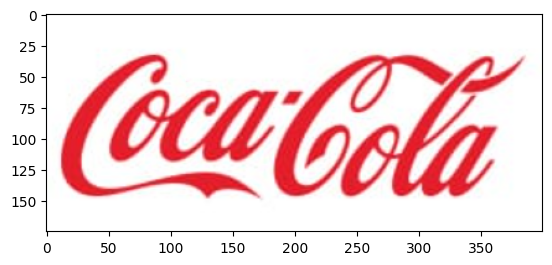

In [2]:
img = cv.imread('./template/pattern.png')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
def plot_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

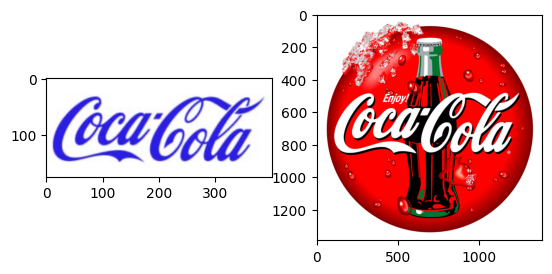

In [5]:
img = cv.imread('./images/COCA-COLA-LOGO.jpg')

img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
template = cv.imread('./template/pattern.png')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_rgb)

In [6]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

for meth in methods:
    img_salida = img_rgb.copy()

    method = eval(meth)

    res = cv.matchTemplate(img_gray, template, method)

    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc

    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
    plt.figure()
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/templmatch.cpp:1164: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'


In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt




In [16]:
print(img1.shape)
print(img2.shape)

(175, 400)
(1389, 1389)


In [98]:
# Cargamos la imagen a buscar
img1 = cv.bitwise_not(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))

# Cargamos la imagen de búsqueda
img2 = cv.imread('./images/COCA-COLA-LOGO.jpg', cv.IMREAD_GRAYSCALE)

orb = cv.ORB_create()
 
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# matches = bf.match(des1, des2)
# matches = sorted(matches, key = lambda x:x.distance)



n=30
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3), plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
> 

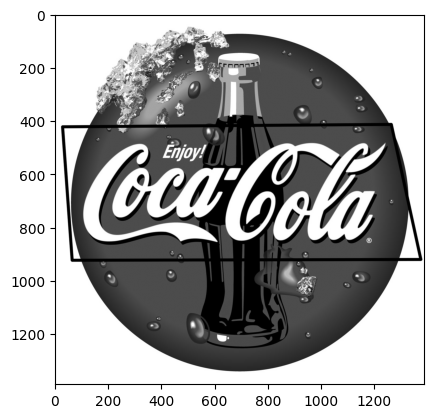

In [96]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches if m.distance < 1.8*matches[0].distance ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches if m.distance < 1.8*matches[0].distance ]).reshape(-1,1,2)
M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv.perspectiveTransform(pts, M)

img2_prime = cv.polylines(img2, [np.int32(dst)], True, 0, 10, cv.LINE_AA)
plt.imshow(img2_prime,  cmap='gray')
plt.show()

In [211]:
def draw_homography(img1, img2, matches, kp1, kp2):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    if M is not None:
        rank = np.linalg.matrix_rank(M)
        print(f"The rank of the homography matrix is: {rank}")
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts, M)
        print(dst)
        # print(M)
        return cv.polylines(img2, [np.int32(dst)], True, 255, 10, cv.LINE_AA)
    else:
        print("Homography could not be found.")
        return img2

def _find_matching_features(img1, img2):
    sift = cv.SIFT_create(
        nfeatures=0,             # Keep all features
        nOctaveLayers=3,         # Default
        contrastThreshold=0.08,  # Lowered from 0.04 to find weaker features
        edgeThreshold=5,        # Increased from 10 to be more lenient on edges
        sigma=1.6                # Default
    )
    # sift = cv.xfeatures2d.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good, kp1, kp2

def find_matching_features(img1, img2):
    orb = cv.ORB_create()
    orb = cv.ORB_create(
        nfeatures=1000,         # Find more features in the scene
        scaleFactor=1.1,        # Use a finer scale pyramid, better for small variations
        patchSize=21,           # Size of the patch used by the BRIEF descriptor. Default is 31.
        fastThreshold=10,       # Lower threshold makes FAST more sensitive. Default is 20.
        WTA_K=4                 # Use 4 points to produce the descriptor instead of 2. More robust.
    )
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    return matches, kp1, kp2
    
def find_image(img1, img2):
    matches, kp1, kp2 = find_matching_features(img1, img2)
    img_keyponits = cv.drawKeypoints(img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_keyponits)
    plt.show()

    if len(matches) < 10:
        print('too few good points')
    else:
        img2 = draw_homography(img1, img2, matches, kp1, kp2)
        
    n=30
    img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)
    plt.show()

In [216]:
def draw_rect(img, points):
    rect = cv2.minAreaRect(points)
    box_points = cv2.boxPoints(rect)
    box_points = np.intp(box_points)
    return cv2.drawContours(img, [box_points], 0, 255, 5)
    
def find_multi_image(img1, img2):
    h, w = img1.shape
    
    orb = cv.ORB_create(
        nfeatures=1000,         # Find more features in the scene
        scaleFactor=1.1,        # Use a finer scale pyramid, better for small variations
        patchSize=21,           # Size of the patch used by the BRIEF descriptor. Default is 31.
        fastThreshold=10,       # Lower threshold makes FAST more sensitive. Default is 20.
        WTA_K=4                 # Use 4 points to produce the descriptor instead of 2. More robust.
    )
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    img_keyponits = cv.drawKeypoints(img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_keyponits)
    plt.show()

    all_points_img2 = np.float32([kp.pt for kp in kp2])
    MIN_CLUSTER_SIZE = 5
    EPSILON_DISTANCE = 20 

    db = DBSCAN(eps=EPSILON_DISTANCE, min_samples=MIN_CLUSTER_SIZE).fit(all_points_img2)
    labels = db.labels_

    unique_labels = set(labels)
    num_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    print(f"DBSCAN found {num_clusters} potential character clusters.")
    # print(labels)
    img_output = img2.copy()

    n=30
    # img3 = cv.drawMatches(img1,kp1,img_output,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # plt.imshow(img3)
    # plt.show()
    for cluster_label in unique_labels:
        # Skip the noise cluster
        print(f'Cluster {cluster_label}')

        if cluster_label == -1:
            continue
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_kp =  np.array(kp2)[cluster_indices]
        cluster_des =  np.array(des2)[cluster_indices]
        
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, cluster_des)
        matches = sorted(matches, key = lambda x:x.distance)
        if len(matches) > 4: 
            img_keyponits = cv.drawKeypoints(img2, cluster_kp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            # plt.imshow(draw_homography(img1, img_keyponits, matches, kp1, cluster_kp))
            clister_points = np.float32([ cluster_kp[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
            plt.imshow(draw_rect(img_keyponits, clister_points))
            plt.show()
            img_output = draw_homography(img1, img_output, matches, kp1, cluster_kp)
        else:
            print("Too few good matches")
            


    n=30
    # img3 = cv.drawMatches(img1,kp1,img_output,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_output)
    plt.show()

(175, 400)


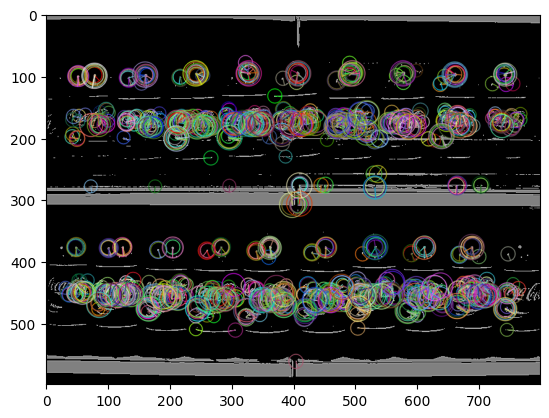

DBSCAN found 36 potential character clusters.
Cluster 0


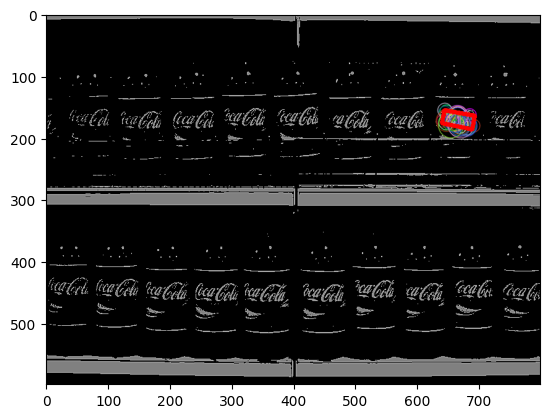

The rank of the homography matrix is: 3
[[[684.35    178.47192]]

 [[680.5701  175.22325]]

 [[683.6009  177.68288]]

 [[679.1375  174.19058]]]
Cluster 1


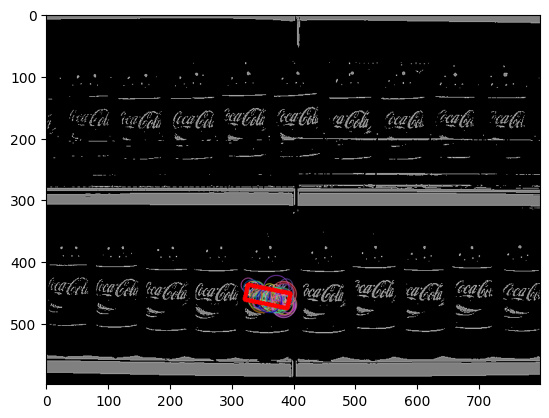

The rank of the homography matrix is: 3
[[[373.45593 463.5392 ]]

 [[365.722   461.69183]]

 [[371.95743 462.17484]]

 [[362.58627 462.01947]]]
Cluster 2


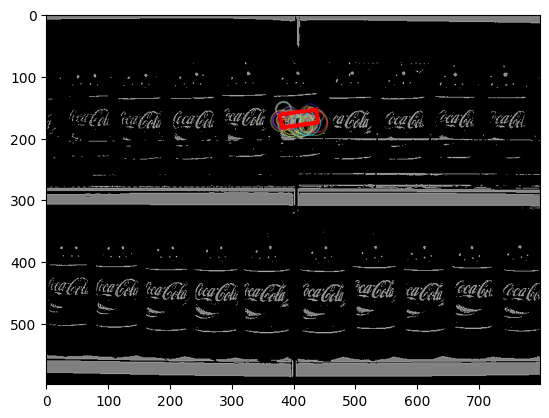

The rank of the homography matrix is: 3
[[[428.29837 180.39185]]

 [[399.76703 179.03575]]

 [[359.31775 173.5464 ]]

 [[376.19434 185.40558]]]
Cluster 3


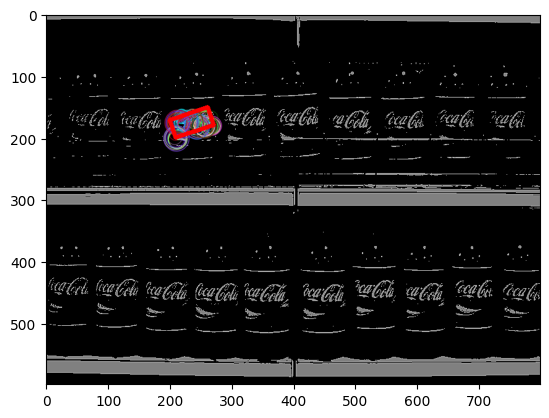

The rank of the homography matrix is: 3
[[[258.21704 181.82518]]

 [[243.84758 181.6427 ]]

 [[259.67636 181.95152]]

 [[263.95367 181.4115 ]]]
Cluster 4


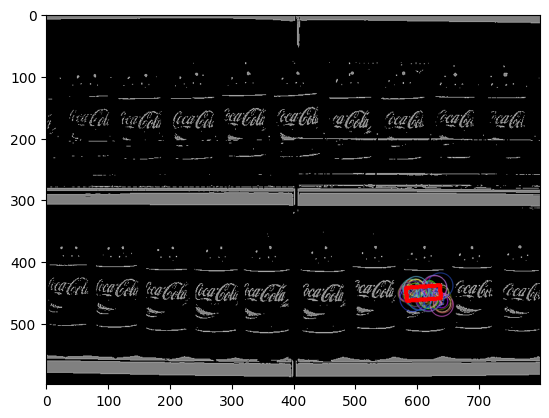

The rank of the homography matrix is: 3
[[[619.0643  463.9086 ]]

 [[618.16425 459.6364 ]]

 [[618.12164 463.15277]]

 [[618.2548  459.46747]]]
Cluster 5


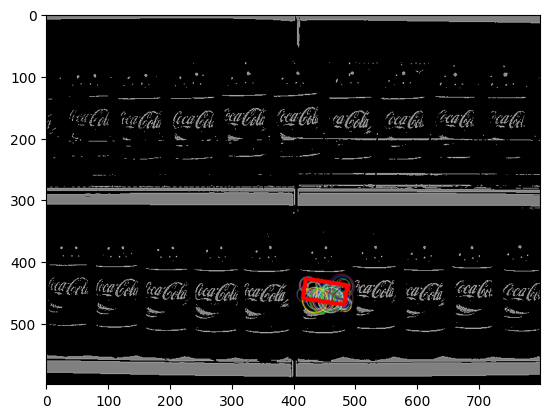

The rank of the homography matrix is: 3
[[[  498.16205   468.9863 ]]

 [[  482.8758    467.34225]]

 [[-1008.6055    289.3006 ]]

 [[  468.01865   465.4572 ]]]
Cluster 6


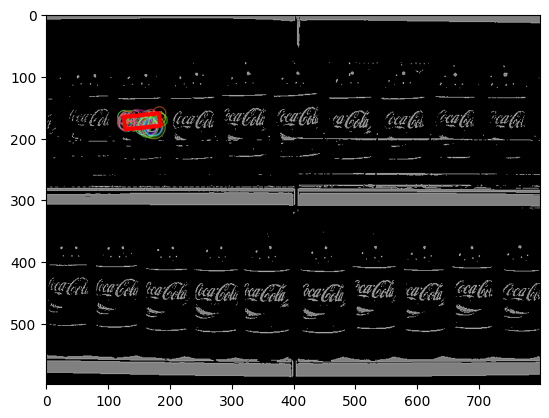

The rank of the homography matrix is: 3
[[[126.52675 163.28096]]

 [[189.59244 187.05336]]

 [[ 96.20627 156.14429]]

 [[176.65392 183.38164]]]
Cluster 7


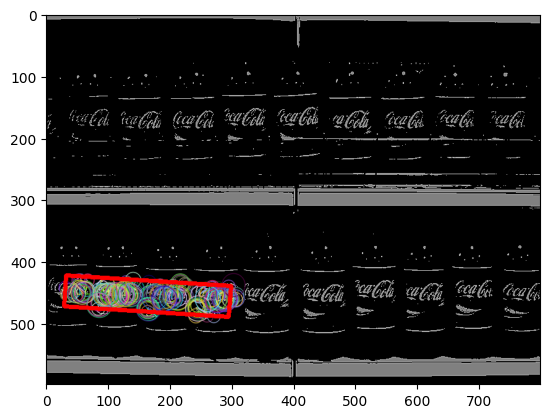

The rank of the homography matrix is: 3
[[[293.0793  460.67303]]

 [[294.94568 461.81842]]

 [[303.81165 461.46634]]

 [[291.70352 461.56418]]]
Cluster 8


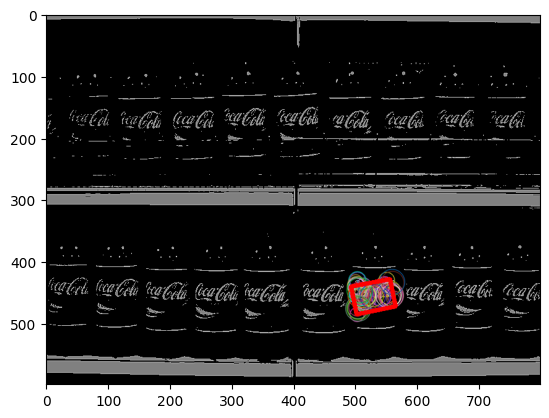

The rank of the homography matrix is: 3
[[[451.29257 445.30508]]

 [[506.05447 451.61768]]

 [[542.89624 454.56113]]

 [[504.32587 451.6475 ]]]
Cluster 9


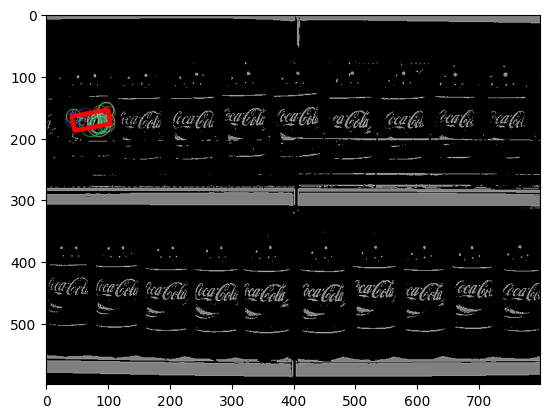

The rank of the homography matrix is: 3
[[[ 46.31652  194.7905  ]]

 [[ 93.237206 179.35625 ]]

 [[ 79.10716  182.30315 ]]

 [[100.35166  185.1933  ]]]
Cluster 10


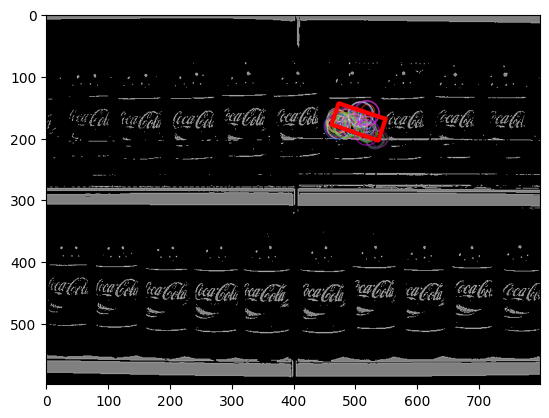

The rank of the homography matrix is: 3
[[[496.57944 180.57193]]

 [[507.13034 181.08261]]

 [[498.51205 180.59227]]

 [[499.5978  180.79074]]]
Cluster 11


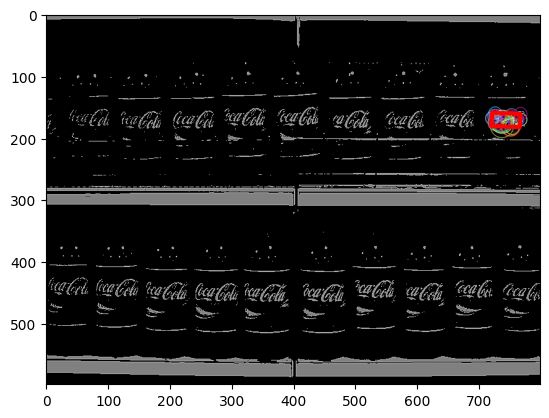

The rank of the homography matrix is: 3
[[[758.78375 183.98633]]

 [[737.83954 179.41171]]

 [[898.13556 219.88243]]

 [[671.9911  171.77727]]]
Cluster 12
Too few good matches
Cluster 13


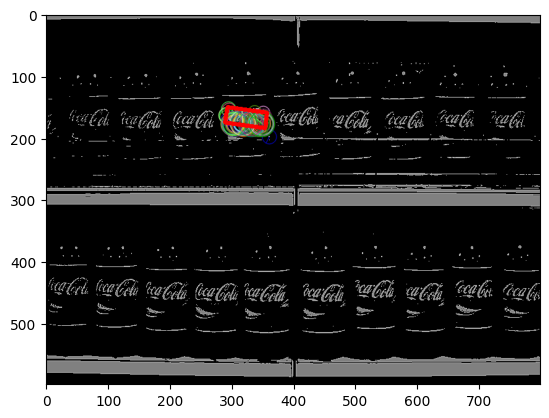

The rank of the homography matrix is: 3
[[[323.24103 153.93883]]

 [[331.0036  176.37349]]

 [[353.8528  238.22668]]

 [[331.2034  177.14294]]]
Cluster 14


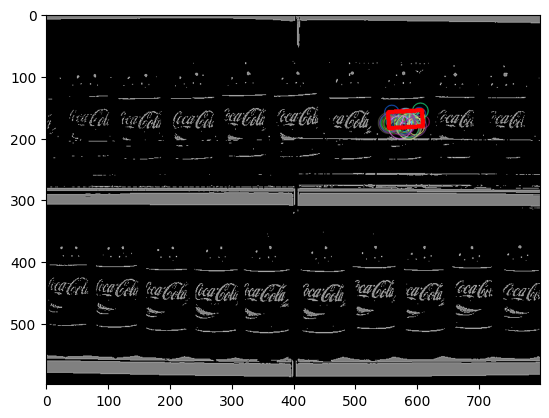

The rank of the homography matrix is: 3
[[[583.2429  176.09996]]

 [[569.8577  164.40135]]

 [[581.78204 175.36607]]

 [[615.5446  212.23251]]]
Cluster 15


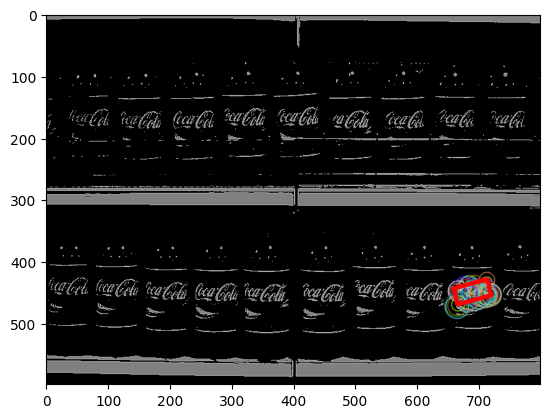

The rank of the homography matrix is: 3
[[[731.6785  456.9648 ]]

 [[708.2342  463.20667]]

 [[558.31775 450.43042]]

 [[699.62134 456.81183]]]
Cluster 16


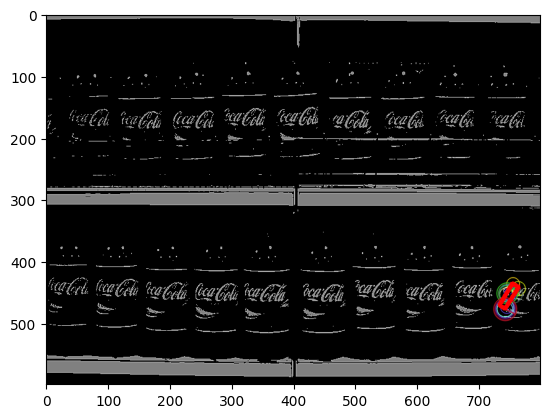

The rank of the homography matrix is: 3
[[[750.7412  442.33276]]

 [[748.3814  442.5769 ]]

 [[742.47095 456.90768]]

 [[746.4594  448.85782]]]
Cluster 17
Too few good matches
Cluster 18


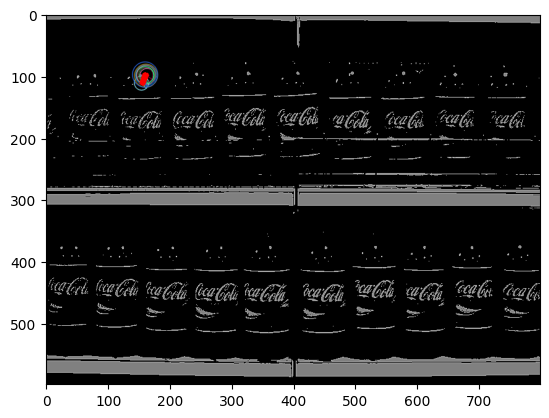

The rank of the homography matrix is: 3
[[[161.10504   97.946754]]

 [[161.05621   97.96376 ]]

 [[161.07362   98.0199  ]]

 [[161.14568   97.735   ]]]
Cluster 19
Too few good matches
Cluster 20


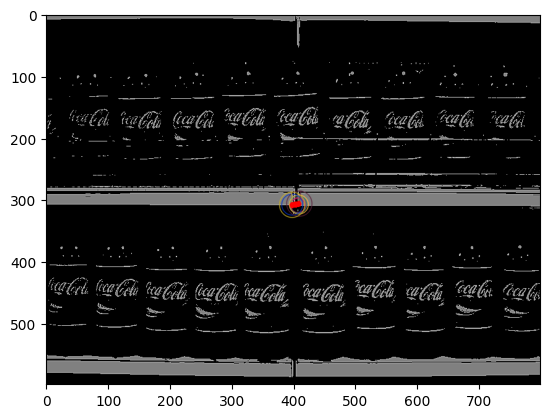

The rank of the homography matrix is: 3
[[[407.5714  309.34152]]

 [[407.30618 309.31577]]

 [[407.47757 309.32483]]

 [[407.2858  309.30386]]]
Cluster 21


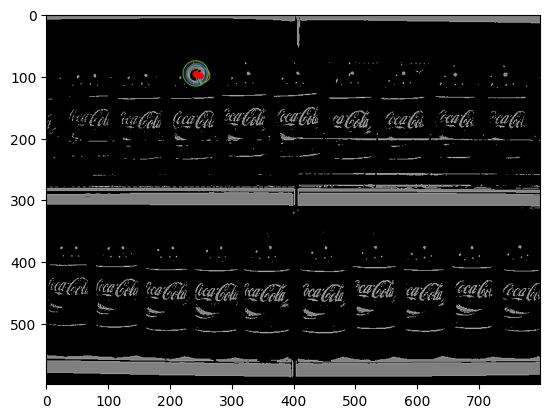

The rank of the homography matrix is: 3
[[[258.09454  117.957664]]

 [[242.88036   98.45023 ]]

 [[243.75917   99.06087 ]]

 [[242.87509   98.846085]]]
Cluster 22


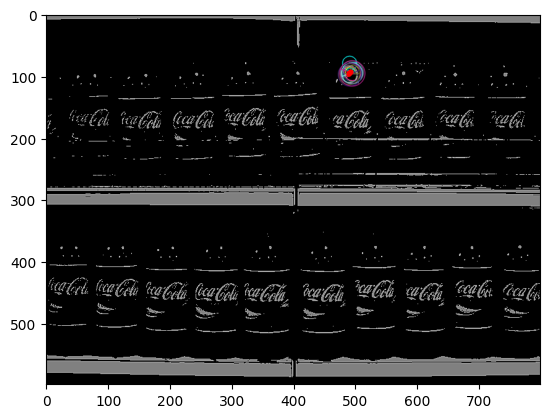

The rank of the homography matrix is: 3
[[[489.7062    96.8934  ]]

 [[489.79642   96.477585]]

 [[489.71182   96.7782  ]]

 [[489.86356   96.36672 ]]]
Cluster 23


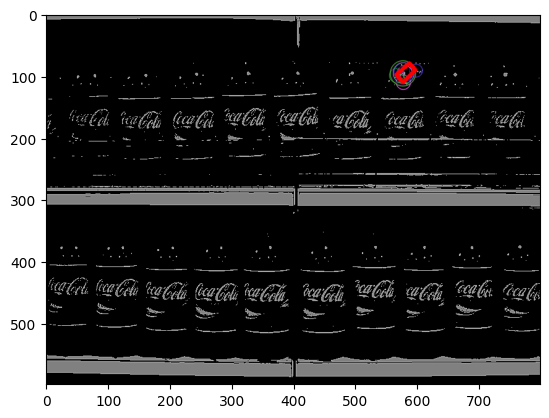

The rank of the homography matrix is: 3
[[[572.4451    96.66406 ]]

 [[578.5211    95.550255]]

 [[575.53925   95.39767 ]]

 [[578.21094   95.70667 ]]]
Cluster 24


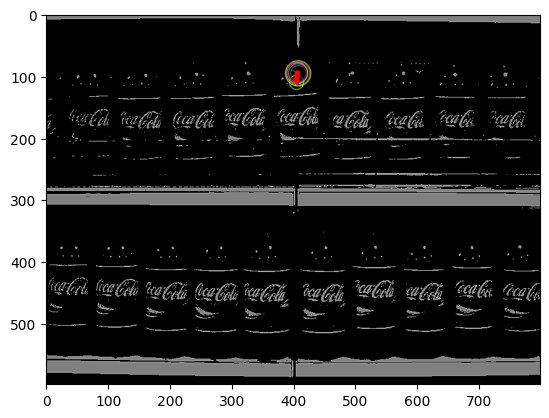

The rank of the homography matrix is: 3
[[[407.1633    95.32842 ]]

 [[407.59604   95.51696 ]]

 [[407.1384    95.29643 ]]

 [[408.37872   95.964455]]]
Cluster 25
Too few good matches
Cluster 26
Too few good matches
Cluster 27


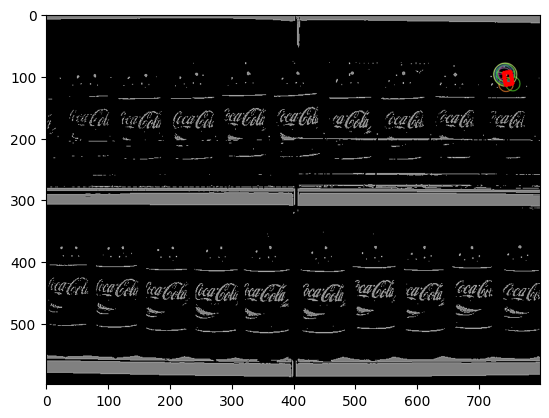

The rank of the homography matrix is: 3
[[[741.9599   98.31092]]

 [[741.56793  99.56748]]

 [[741.9472   99.13512]]

 [[741.56683  98.87499]]]
Cluster 28


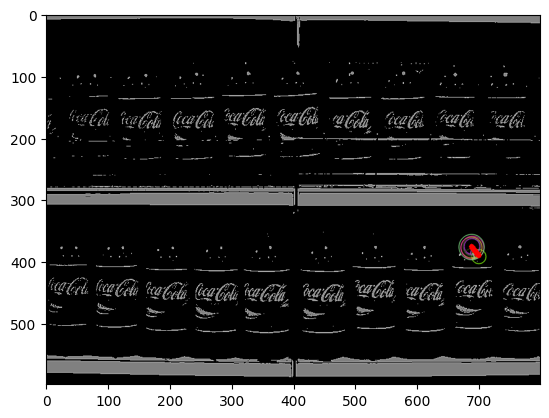

The rank of the homography matrix is: 3
[[[734.8544 453.6201]]

 [[681.6396 372.444 ]]

 [[694.2716 389.2152]]

 [[676.0111 366.8611]]]
Cluster 29


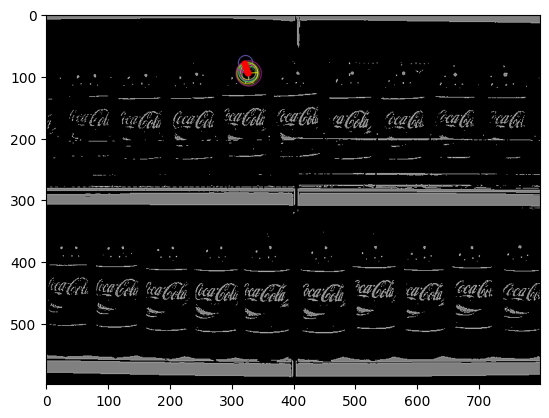

The rank of the homography matrix is: 3
[[[330.83636  103.891396]]

 [[325.03607   88.923546]]

 [[365.80243  194.63843 ]]

 [[321.82635   80.83227 ]]]
Cluster 30


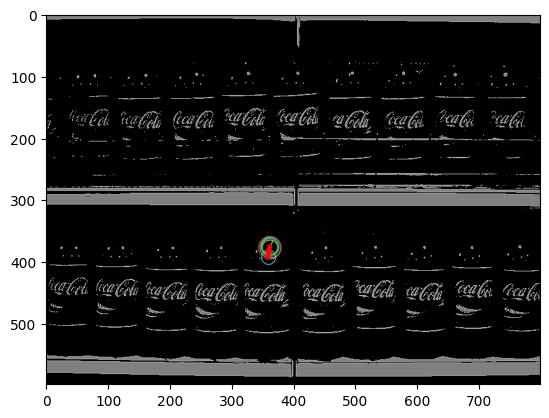

The rank of the homography matrix is: 3
[[[362.2462  375.9053 ]]

 [[365.32224 368.4221 ]]

 [[362.32205 375.66208]]

 [[363.00302 374.38696]]]
Cluster 31


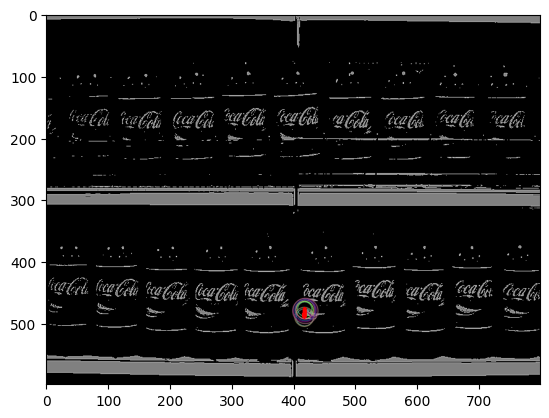

Homography could not be found.
Cluster 32


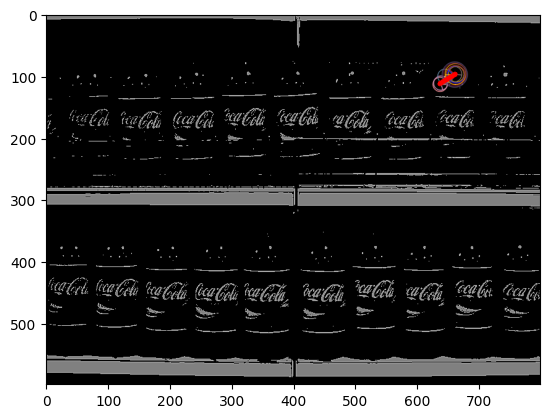

The rank of the homography matrix is: 3
[[[702.36163   72.58793 ]]

 [[664.6665    95.649574]]

 [[672.8929    90.587524]]

 [[674.80865   89.55514 ]]]
Cluster 33


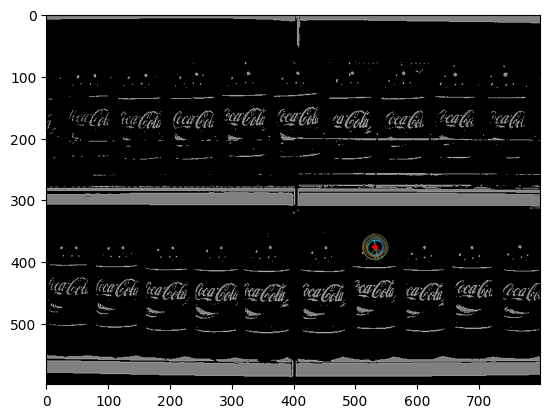

Homography could not be found.
Cluster 34


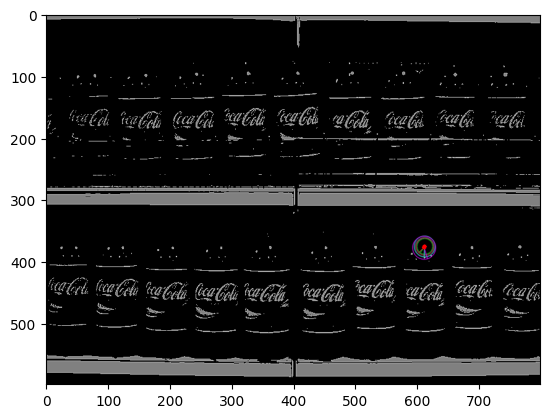

Homography could not be found.
Cluster 35
Too few good matches
Cluster -1


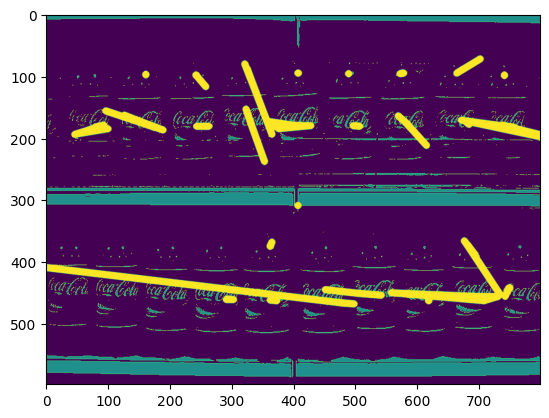

In [217]:
def apply_clahe(img):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def sharpenning(img):
    blurred = cv.GaussianBlur(img, (5, 5), 0)
    return cv.addWeighted(img, 1, blurred, -.5, 0)

# Cargamos la imagen a buscar
img1 = cv.bitwise_not(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))
img1 = cv.threshold(img1, 50, 255, cv.THRESH_BINARY)[1]
# img1 = cv.bitwise_not(img1)
print(img1.shape)
img2 = cv.imread('./images/coca_multi.png', cv.IMREAD_GRAYSCALE)

img2 = cv.imread('./images/coca_multi.png', cv.IMREAD_GRAYSCALE)
img2 = cv.threshold(img2, 210, 255, cv.THRESH_BINARY)[1]
img2_eq = cv.equalizeHist(img2)

alpha = 0.4  # Contrast control (1.0-3.0)
beta = 50     # Brightness control (0-100)
img2_eq = cv.convertScaleAbs(img2_eq, alpha=alpha, beta=beta)

blurred = cv.GaussianBlur(img2, (3, 3), 0)
adaptive_thresh = cv.adaptiveThreshold(
    blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv.THRESH_BINARY_INV, 11, 2
)
kernel = np.ones((2,2), np.uint8)
cleaned_image = cv.morphologyEx(adaptive_thresh, cv.MORPH_OPEN, kernel)


# find_image(cv.threshold(img1, 50, 255, cv.THRESH_BINARY)[1], img2[:300,:110])
# find_image(cv.threshold(img1, 50, 255, cv.THRESH_BINARY)[1], img2[:300,:410])
# find_image(img1, img2)
find_multi_image(img1, sharpenning(img2))
# find_multi_image(img1, cleaned_image)
# find_multi_image(img1, cv.bitwise_not(cleaned_image))

In [ ]:
# sift = cv.xfeatures2d.SIFT_create()
# # img1 = cv.threshold(img1, 50, 255, cv.THRESH_BINARY)[1]
# kp1, des1 = sift.detectAndCompute(img1,None)
# kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)

# flann = cv.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(des1,des2,k=2)
orb = cv.ORB_create()
 
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)


n=60
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [106]:
import cv2
import numpy as np

# --- DIAGNOSTIC CODE ---

template_path = './template/pattern.png'
scene_path = './images/coca_multi.png'
# img1 = cv.bitwise_not(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))
# img1 = cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE)
# Cargamos la imagen de búsqueda
# img2 = cv.imread('./images/coca_multi.png', cv.IMREAD_GRAYSCALE)
img_template = cv2.bitwise_not(cv2.imread('./template/pattern.png', cv2.IMREAD_GRAYSCALE))

# img_template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
img_scene = cv2.imread(scene_path, cv2.IMREAD_GRAYSCALE)[:300,:110]



# Initialize SIFT
sift = cv2.SIFT_create()
sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
# Find keypoints
kp_template, des_template = sift.detectAndCompute(img_template, None)
kp_scene, des_scene = sift.detectAndCompute(img_scene, None)

print(f"Keypoints found in template: {len(kp_template)}")
print(f"Keypoints found in scene: {len(kp_scene)}")

# Draw keypoints on the images
img_template_kp = cv2.drawKeypoints(img_template, kp_template, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_scene_kp = cv2.drawKeypoints(img_scene, kp_scene, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the images with keypoints
cv2.imshow('Template Keypoints', img_template_kp)
cv2.imshow('Scene Keypoints', img_scene_kp)
cv2.waitKey(0)
cv2.destroyAllWindows()

Keypoints found in template: 211
Keypoints found in scene: 282


In [263]:
# --- Apply CLAHE to the scene before SIFT ---
img_scene = cv2.imread(scene_path, cv2.IMREAD_GRAYSCALE)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
scene_enhanced = clahe.apply(img_scene)

# Now, run SIFT on 'scene_enhanced' instead of 'img_scene'
kp_scene, des_scene = sift.detectAndCompute(scene_enhanced, None)

# Don't forget to draw the keypoints on the enhanced scene to see the difference!
img_scene_kp_enhanced = cv2.drawKeypoints(scene_enhanced, kp_scene, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow('Enhanced Scene Keypoints', img_scene_kp_enhanced)
cv2.waitKey(0)

27

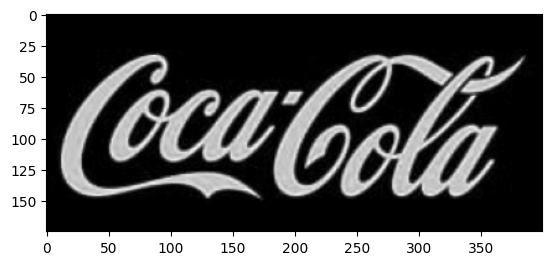

(175, 400)


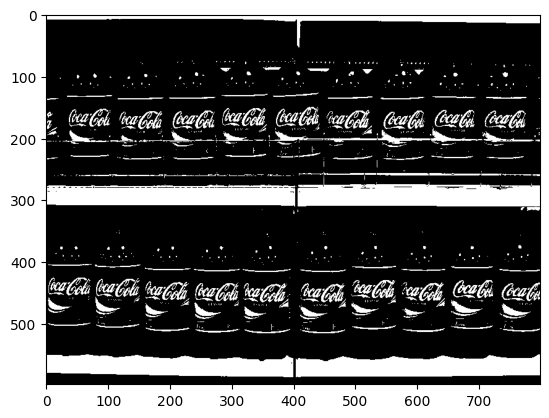

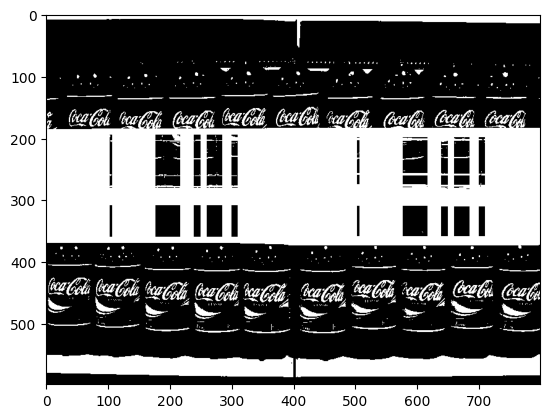

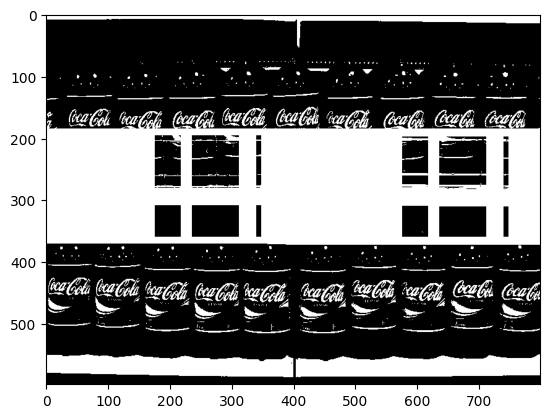

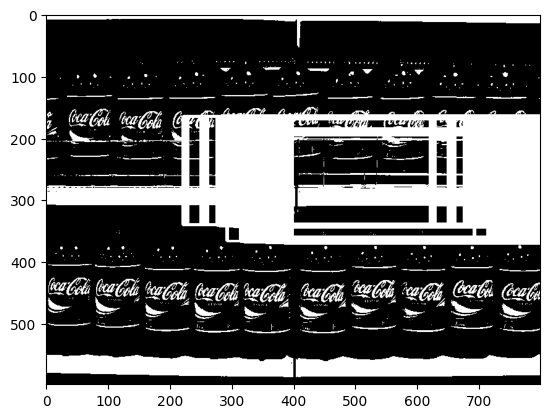

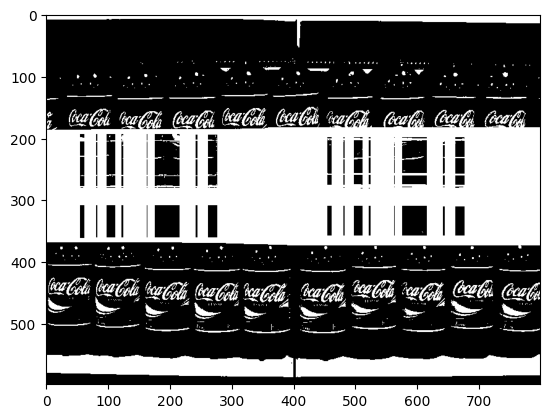

In [140]:
# Cargamos la imagen a buscar
img1 = cv.bitwise_not(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))
# img1 = cv.threshold(img1, 50, 255, cv.THRESH_BINARY)[1]
# img1 = cv.bitwise_not(img1)

plt.imshow(img1, cmap='gray')
plt.show()
print(img1.shape)
img2 = cv.imread('./images/coca_multi.png', cv.IMREAD_GRAYSCALE)

img2 = cv.threshold(img2, 180, 255, cv.THRESH_BINARY)[1]
plt.imshow(img2, cmap='gray')
plt.show()
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED']
# methods = ['cv.TM_CCOEFF_NORMED']
result = None
for meth in methods:
    output_image = img2.copy()

    method = eval(meth)
    h, w = img1.shape
    result = cv.matchTemplate(img2, img1, method)
    criteria = np.quantile(result, 0.99)
    result = np.where(result>criteria)
    locations = list(zip(*result[::-1]))

    
    
    for top_left in locations:
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv.rectangle(output_image, top_left, bottom_right, 255, 2) # Red rectangle
    plt.imshow(output_image, cmap='gray')
    plt.show()

np.float32(0.20695148)

In [149]:

img2 = cv.imread('./images/coca_retro_1.png', cv.IMREAD_GRAYSCALE)
img1 = cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE)

find_image(img1, img2)

coca_logo_1.png


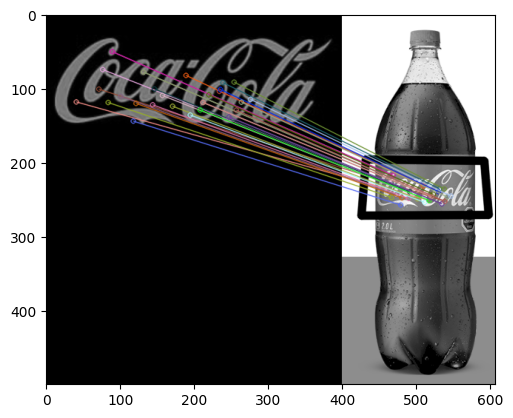

coca_logo_2.png


coca_multi.png
too few good points


coca_retro_1.png
too few good points


coca_retro_2.png


logo_1.png


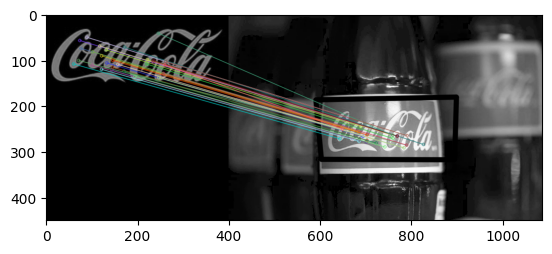

In [134]:
import os
images = filter(lambda filename: 'png' in  filename, os.listdir('./images/'))
for image in images:
    print(image)
    img = cv.imread('./images/' + image, cv.IMREAD_GRAYSCALE)
    find_image(img1, img)

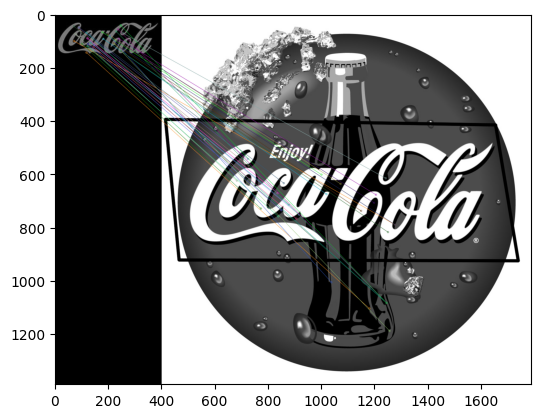

(<matplotlib.image.AxesImage at 0x7ff6aa02f750>, None)

In [103]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv.perspectiveTransform(pts, M)

img2_prime = cv.polylines(img2, [np.int32(dst)], True, 0, 10, cv.LINE_AA)
n=30
img3 = cv.drawMatches(img1,kp1,img2_prime,kp2,good[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3), plt.show()


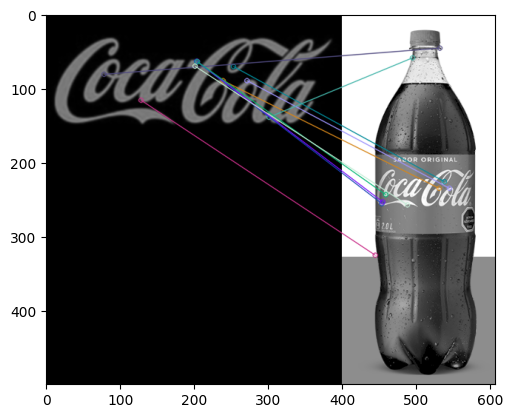

(<matplotlib.image.AxesImage at 0x7ff70c5c1590>, None)

In [21]:
# Cargamos la imagen a buscar
img1 = cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE)

img1 = cv.GaussianBlur(img1, (5, 5), 0)
img1 = cv.bitwise_not(img1)

# Cargamos la imagen de búsqueda
img2 = cv.imread('./images/coca_logo_1.png', cv.IMREAD_GRAYSCALE)
orb = cv.ORB_create()
 
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# bf = cv.BFMatcher()

matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)

n=10
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3), plt.show()

108
2848


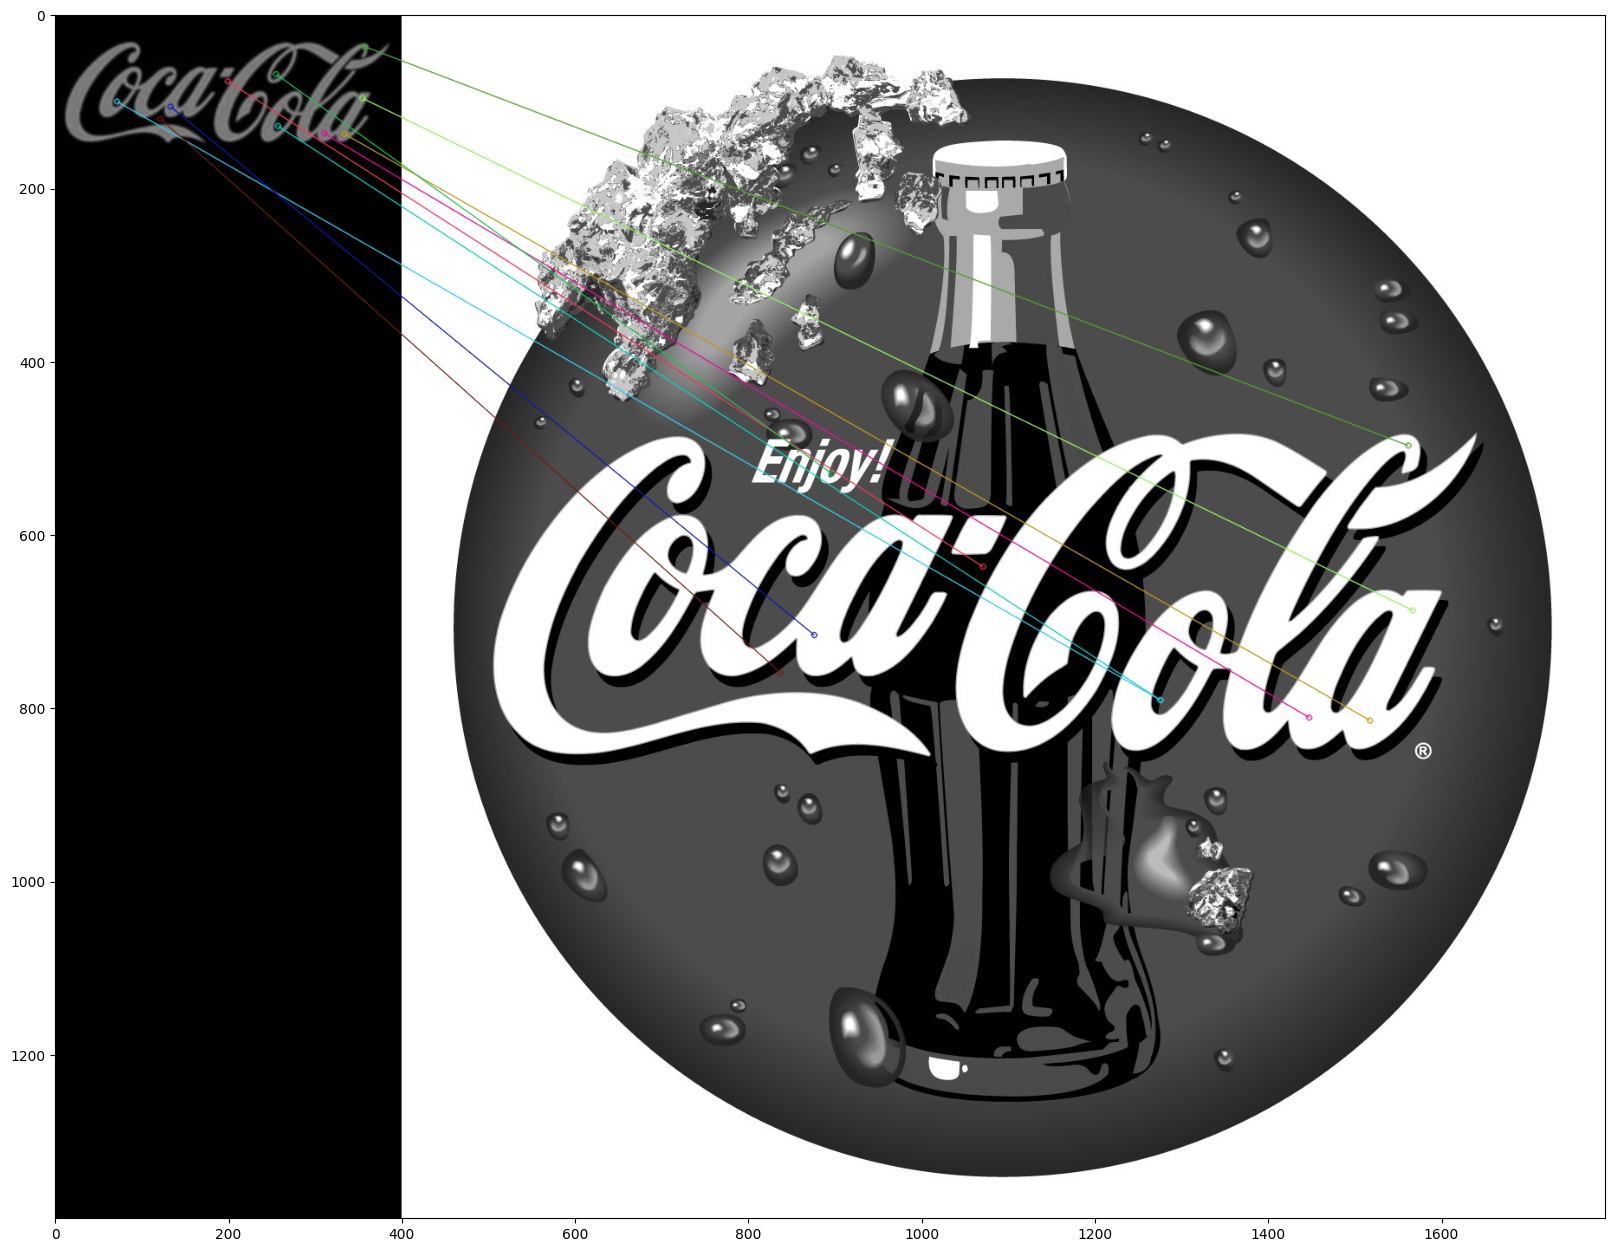

(<matplotlib.image.AxesImage at 0x7ff70c5df390>, None)

In [22]:
# Cargamos la imagen a buscar
img1 = cv.bitwise_not(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))
img1 = cv.GaussianBlur(img1, (5, 5), 0)
# Cargamos la imagen de búsqueda
img2 = cv.imread('./images/COCA-COLA-LOGO.jpg', cv.IMREAD_GRAYSCALE)

# Creamos el vector de características SIFT
sift = cv.xfeatures2d.SIFT_create()

# Y buscamos según el algoritmo...
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

print(len(kp1))
print(len(kp2))

# BFMatcher con parámetros por defecto
bf = cv.BFMatcher()
# K es la cantidad de "best matches" para cada descriptor
matches = bf.knnMatch(des1, des2, k=2)

# Aplicar test de proporción
good = []
for m, n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

# Los ordenamos según distancia
good = sorted(good, key = lambda x:x.distance)
# Dibujamos las primeras N coincidencias (las mejores)
N = 10

# cv.drawMatchesKnn espera una lista de listas como coincidencias
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, [good[:N]], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_DEFAULT)
plt.figure(figsize=(20,20))
plt.imshow(img3),plt.show()

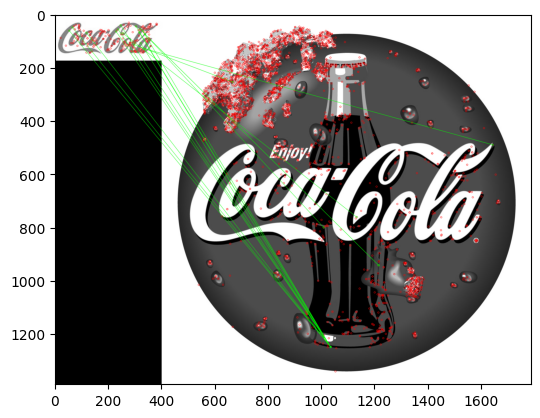

(<matplotlib.image.AxesImage at 0x7ff714436210>, None)

In [5]:
# parámetros FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # o pasar un diccionario vacío
flann = cv.FlannBasedMatcher(index_params,search_params)
# K es la cantidad de "best matches" para cada descriptor
matches = flann.knnMatch(des1, des2, k=2)

# Necesidad de dibujar solo las coincidencias buenas, se crea una máscara
matchesMask = [[0,0] for i in range(len(matches))]

# Ratio de verificación como figura en el paper de Lowe
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()